## TODO:
1. Initialize parameter defining no. of points
2. Should the network jest recieve one point each time or a batch?
3. function for boundary conditions

In [1]:
import sys
sys.path.insert(0, './Utilities/')


from collections import OrderedDict


import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import torch
from pyDOE import lhs

np.random.seed(1234)

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/home/guy_a/anaconda3/envs/pytorch/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## Configuration`

In [2]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class CNN(torch.nn.Module):
    def __init__(self, layers):
        super(CNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
def calc_u_pred(model):
    u_pred, f_pred = model.predict(X_star)
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    return U_pred

def plotter(tc,xc,U_pred):
    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15) 

    # ax.plot(
    #     X_u_train[:,1], 
    #     X_u_train[:,0], 
    #     'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    #     markersize = 4,  # marker size doubled
    #     clip_on = False,
    #     alpha=1.0
    # )

    ax.plot(
        xc,
        tc,     
        'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
        markersize = 4,  # marker size doubled
        clip_on = False,
        alpha=1.0
    )


    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

    ax.set_xlabel('$t$', size=20)
    ax.set_ylabel('$x$', size=20)
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.9, -0.05), 
        ncol=5, 
        frameon=False, 
        prop={'size': 15}
    )
    ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
    ax.tick_params(labelsize=15)

    plt.show()

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, dnn_layers, cnn_layers, lb, ub, nu):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.dnn_layers = dnn_layers
        self.cnn_layers = cnn_layers
        self.nu = nu
        
        # deep neural networks
        self.cnn = CNN(cnn_layers).to(device)
        self.dnn = DNN(dnn_layers).to(device)
        
        # optimizers: using the same settings
        self.d_optimizer = torch.optim.Adam(self.dnn.parameters(),lr = 0.01)#, momentum=0.9)
        self.c_optimizer = torch.optim.Adam(self.dnn.parameters(),lr = 0.01)

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_c(self, x, t):  
        c = self.cnn(torch.cat([t,x], dim=1))
        cx,ct= self.normalize_range(c[:,-1:],c[:,0:1])
        cc =  torch.cat((ct,cx),dim=1)
        orig_boundaries = torch.cat((model.t_u,model.x_u),dim=1)
        skeleton = torch.cat(((model.t_u==0).int(),(model.x_u==1).int() + (model.x_u==-1).int()),dim=1)
        anti_skeleton = 1-skeleton
        xt = skeleton*orig_boundaries + anti_skeleton*cc
#         print(xt)
        return xt[:,-1:],xt[:,0:1]

    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xt = torch.autograd.grad(
            u_x, t, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
#         f = u_t + u * u_x - self.nu * u_xx
        f = u_tt - self.nu * u_xx
        return f
    
    
    def train1(self,epochs=500):
        self.dnn.train()
#         self.cnn.train()
        for epoch in range(epochs):
            self.d_optimizer.zero_grad()
#             self.c_optimizer.zero_grad()
#             cx,ct = self.net_c(self.x_u, self.t_u)
            u_pred = self.net_u(self.x_u, self.t_u)
            f_pred = self.net_f(self.x_f, self.t_f)
            loss_u = torch.mean((self.u - u_pred) ** 2)
            loss_f = torch.mean(f_pred ** 2)
            a,b=1,1
            loss = a*loss_u + b*loss_f
            loss.backward(retain_graph=True)
#             self.c_optimizer.step()
            self.d_optimizer.step()
            cx,ct = self.x_u, self.t_u
            if epoch % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (epoch, loss.item(), loss_u.item(), loss_f.item())
                )
                if epoch % 1000 == 0:
                    U_pred = calc_u_pred(model)
                    plotter(cx.detach().cpu().numpy(),ct.detach().cpu().numpy(),U_pred)
                    if (100*loss_f)<loss_u:
                        b = loss_u/loss_f
                        a = 1
                    elif (100*loss_u)<loss_f:
                        a = loss_u/loss_f
                        b = 1
                
    def normalize_range(self,x,t):
        tn = (t-t.min())/(t.max()-t.min())
        xn = -1+2*(x-x.min())/(x.max()-x.min())
        return xn,tn
    
    def train2(self,epochs=100):
        self.dnn.train()
        self.cnn.train()
        cx,ct = self.x_u, self.t_u
        for epoch in range(epochs):
            self.d_optimizer.zero_grad()
#             self.c_optimizer.zero_grad()
            cx,ct = self.net_c(self.x_u, self.t_u)
            
            u_pred = self.net_u(cx,ct)
            f_pred = self.net_f(self.x_f, self.t_f)
            
            ti = ct#[model.t_u!=0]
            xi = cx#[torch.abs(model.x_u)<1]
            t_dist = torch.abs(ti.unsqueeze(1)-ti)**3
            x_dist = torch.abs(xi.unsqueeze(1)-xi)**3
            
            loss_u = torch.mean((self.u - u_pred) ** 2)
            loss_f = torch.mean(f_pred ** 2)
            loss_dist = 1/(torch.sum(t_dist) + torch.sum(x_dist))#*10**12
            loss2 = loss_dist #+loss_u + loss_f 
            loss2.backward(retain_graph=True)
#             self.c_optimizer.step()
            self.d_optimizer.step()
            if epoch % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Loss_dist: %.5e' % (epoch, loss2.item(), loss_u.item(), loss_f.item(), loss_dist.item())
                )
#                 print("ct",ct)
                U_pred = calc_u_pred(model)
                plotter(cx.detach().cpu().numpy(),ct.detach().cpu().numpy(),U_pred)
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
#         self.cnn.eval()
        self.dnn.eval()
#         x,t = self.net_c(x, t)
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [33]:
t = np.arange(0,10,0.01)

In [42]:
x = np.arange(-2,2,0.01)
len(x)

400

In [63]:
nu = 0.5/np.pi
noise = 0.0        

N_u = 2000
N_f = 10000
dnn_layers = [2, 8,8,8,8,8,8,8,8,8,8,8,8,8, 1]
cnn_layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2]

data = scipy.io.loadmat('data/burgers_shock.mat')

#t and x are used for a meshgrid:
# t = data['t'].flatten()[:,None]
t = np.arange(0,10,0.01)
l_t=len(t)
# x = data['x'].flatten()[:,None]
x = np.arange(-2,2,0.01)
l_x=len(x)
#what exactly is Exact?
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
# uu1 = Exact[0:1,:].T
xox = np.arange(l_x)/40
xox = np.expand_dims(x,axis=1)
xyx = (np.arange(l_t)-l_t/2)/20
xyx = -np.expand_dims(xyx,axis=1)**2
uu1 = np.sin(xox)*np.exp(-xox**2)
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
# uu2 = Exact[:,0:1]
# uu2 = np.expand_dims(0*np.arange(100)/100,axis=1)
uu2 = -np.exp(xyx)
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
# uu3 = Exact[:,-1:]
uu3 = np.expand_dims(0*np.arange(l_t)/100,axis=1)
# uu3 = np.exp(xyx)/10
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

#N_u represents the number of points on the boundary
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

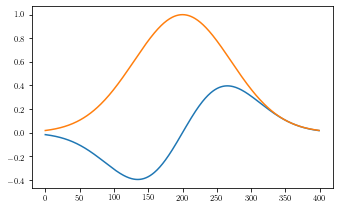

In [65]:
plt.plot(uu1)
plt.plot(np.exp(-x**2))

## Training

In [66]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, dnn_layers,cnn_layers, lb, ub, nu)

Iter 0, Loss: 7.20492e-02, Loss_u: 7.20492e-02, Loss_f: 2.23864e-10


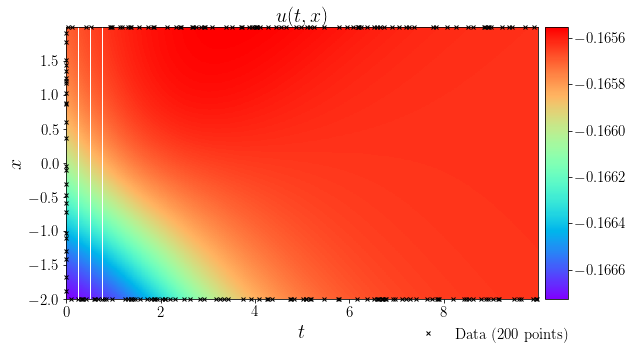

Iter 100, Loss: 1.81281e-02, Loss_u: 1.78917e-02, Loss_f: 2.36404e-04
Iter 200, Loss: 7.66359e-03, Loss_u: 6.82335e-03, Loss_f: 8.40243e-04
Iter 300, Loss: 4.49836e-03, Loss_u: 2.97371e-03, Loss_f: 1.52466e-03
Iter 400, Loss: 4.55952e-03, Loss_u: 3.46636e-03, Loss_f: 1.09315e-03
Iter 500, Loss: 3.26942e-03, Loss_u: 2.10267e-03, Loss_f: 1.16675e-03
Iter 600, Loss: 3.85206e-03, Loss_u: 1.70822e-03, Loss_f: 2.14384e-03
Iter 700, Loss: 4.10973e-03, Loss_u: 3.08484e-03, Loss_f: 1.02489e-03
Iter 800, Loss: 2.60590e-03, Loss_u: 1.49290e-03, Loss_f: 1.11300e-03
Iter 900, Loss: 2.63788e-03, Loss_u: 1.55964e-03, Loss_f: 1.07824e-03
Iter 1000, Loss: 2.58788e-03, Loss_u: 1.50582e-03, Loss_f: 1.08206e-03


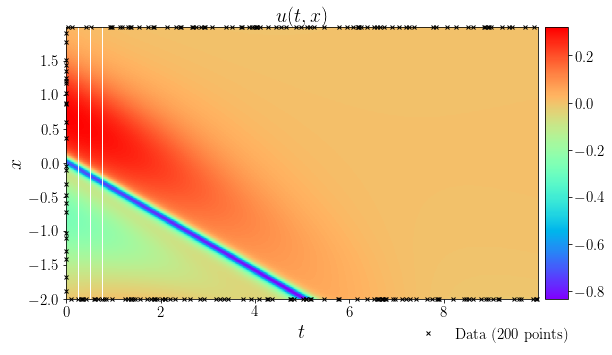

Iter 1100, Loss: 3.23278e-03, Loss_u: 2.08065e-03, Loss_f: 1.15213e-03
Iter 1200, Loss: 3.36397e-03, Loss_u: 2.26689e-03, Loss_f: 1.09708e-03
Iter 1300, Loss: 2.51143e-03, Loss_u: 1.47271e-03, Loss_f: 1.03872e-03
Iter 1400, Loss: 2.39188e-03, Loss_u: 1.32282e-03, Loss_f: 1.06906e-03
Iter 1500, Loss: 2.32979e-03, Loss_u: 1.24924e-03, Loss_f: 1.08056e-03
Iter 1600, Loss: 3.52980e-03, Loss_u: 1.89962e-03, Loss_f: 1.63018e-03
Iter 1700, Loss: 2.35125e-03, Loss_u: 1.21491e-03, Loss_f: 1.13634e-03
Iter 1800, Loss: 4.72205e-03, Loss_u: 3.68587e-03, Loss_f: 1.03619e-03
Iter 1900, Loss: 4.59522e-03, Loss_u: 3.33776e-03, Loss_f: 1.25746e-03
Iter 2000, Loss: 2.36423e-03, Loss_u: 1.27823e-03, Loss_f: 1.08600e-03


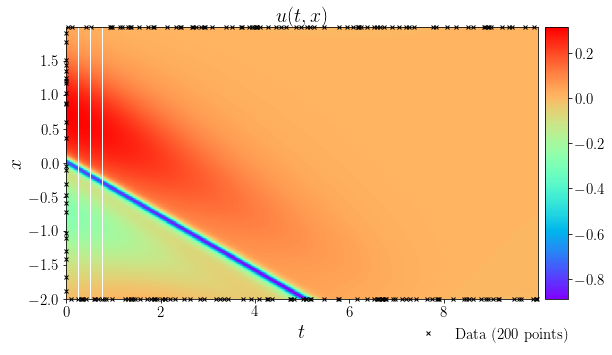

Iter 2100, Loss: 3.60810e-03, Loss_u: 2.37408e-03, Loss_f: 1.23402e-03
Iter 2200, Loss: 2.39345e-03, Loss_u: 1.26974e-03, Loss_f: 1.12372e-03
Iter 2300, Loss: 9.44421e-03, Loss_u: 2.92734e-03, Loss_f: 6.51687e-03
Iter 2400, Loss: 4.01473e-03, Loss_u: 2.77326e-03, Loss_f: 1.24147e-03
Iter 2500, Loss: 2.69163e-03, Loss_u: 1.53364e-03, Loss_f: 1.15799e-03
Iter 2600, Loss: 2.25340e-03, Loss_u: 1.23808e-03, Loss_f: 1.01532e-03
Iter 2700, Loss: 2.27578e-03, Loss_u: 1.21380e-03, Loss_f: 1.06198e-03
Iter 2800, Loss: 3.90473e-03, Loss_u: 2.09815e-03, Loss_f: 1.80657e-03
Iter 2900, Loss: 4.75279e-03, Loss_u: 3.21319e-03, Loss_f: 1.53960e-03
Iter 3000, Loss: 2.22414e-03, Loss_u: 1.17130e-03, Loss_f: 1.05284e-03


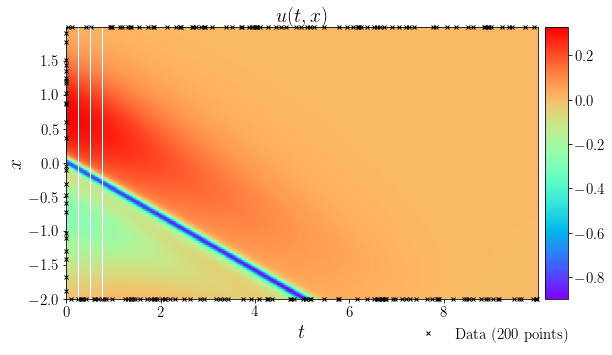

Iter 3100, Loss: 2.36958e-03, Loss_u: 1.33469e-03, Loss_f: 1.03488e-03
Iter 3200, Loss: 2.43032e-03, Loss_u: 1.29609e-03, Loss_f: 1.13423e-03
Iter 3300, Loss: 2.23152e-03, Loss_u: 1.18886e-03, Loss_f: 1.04266e-03
Iter 3400, Loss: 2.32390e-03, Loss_u: 1.28037e-03, Loss_f: 1.04354e-03
Iter 3500, Loss: 2.25295e-03, Loss_u: 1.20329e-03, Loss_f: 1.04965e-03
Iter 3600, Loss: 3.42426e-03, Loss_u: 2.16493e-03, Loss_f: 1.25933e-03
Iter 3700, Loss: 2.27536e-03, Loss_u: 1.22207e-03, Loss_f: 1.05330e-03
Iter 3800, Loss: 5.93959e-03, Loss_u: 4.67088e-03, Loss_f: 1.26871e-03
Iter 3900, Loss: 2.19360e-03, Loss_u: 1.15814e-03, Loss_f: 1.03546e-03
Iter 4000, Loss: 2.07900e-03, Loss_u: 1.07617e-03, Loss_f: 1.00283e-03


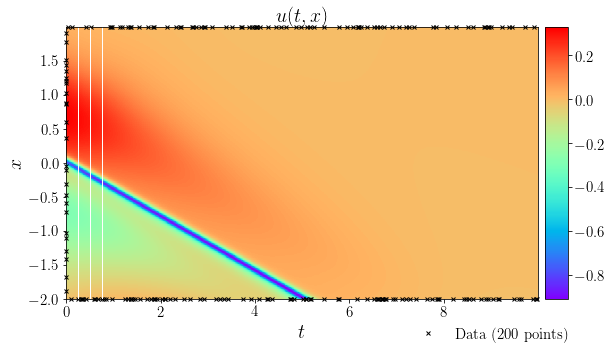

Iter 4100, Loss: 2.03609e-03, Loss_u: 1.05518e-03, Loss_f: 9.80912e-04
Iter 4200, Loss: 3.98598e-03, Loss_u: 3.07765e-03, Loss_f: 9.08327e-04
Iter 4300, Loss: 2.18950e-03, Loss_u: 1.23553e-03, Loss_f: 9.53976e-04
Iter 4400, Loss: 7.04562e-03, Loss_u: 3.72944e-03, Loss_f: 3.31618e-03
Iter 4500, Loss: 2.15244e-03, Loss_u: 1.16490e-03, Loss_f: 9.87537e-04
Iter 4600, Loss: 3.88304e-03, Loss_u: 1.93399e-03, Loss_f: 1.94905e-03
Iter 4700, Loss: 2.07773e-03, Loss_u: 1.10613e-03, Loss_f: 9.71601e-04
Iter 4800, Loss: 1.96664e-03, Loss_u: 1.02136e-03, Loss_f: 9.45281e-04
Iter 4900, Loss: 2.92135e-03, Loss_u: 1.87257e-03, Loss_f: 1.04879e-03
Iter 5000, Loss: 2.19263e-03, Loss_u: 1.25867e-03, Loss_f: 9.33962e-04


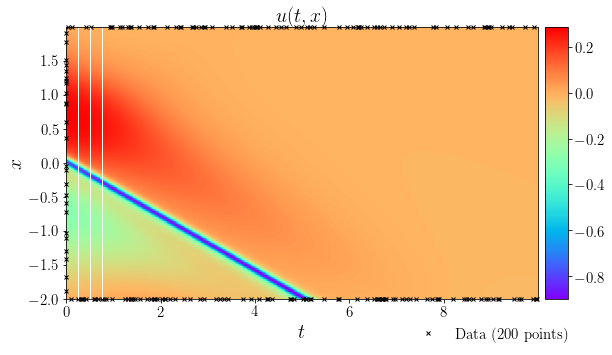

Iter 5100, Loss: 1.96382e-03, Loss_u: 1.01680e-03, Loss_f: 9.47023e-04
Iter 5200, Loss: 2.15588e-03, Loss_u: 1.20943e-03, Loss_f: 9.46454e-04
Iter 5300, Loss: 1.92878e-03, Loss_u: 9.98783e-04, Loss_f: 9.29997e-04
Iter 5400, Loss: 3.15551e-03, Loss_u: 2.27290e-03, Loss_f: 8.82614e-04
Iter 5500, Loss: 2.11429e-03, Loss_u: 1.16689e-03, Loss_f: 9.47408e-04
Iter 5600, Loss: 2.37152e-03, Loss_u: 1.40677e-03, Loss_f: 9.64757e-04
Iter 5700, Loss: 2.02197e-03, Loss_u: 1.15053e-03, Loss_f: 8.71442e-04
Iter 5800, Loss: 2.91918e-03, Loss_u: 1.84925e-03, Loss_f: 1.06993e-03
Iter 5900, Loss: 2.03839e-03, Loss_u: 1.04068e-03, Loss_f: 9.97709e-04
Iter 6000, Loss: 2.27296e-03, Loss_u: 1.32438e-03, Loss_f: 9.48582e-04


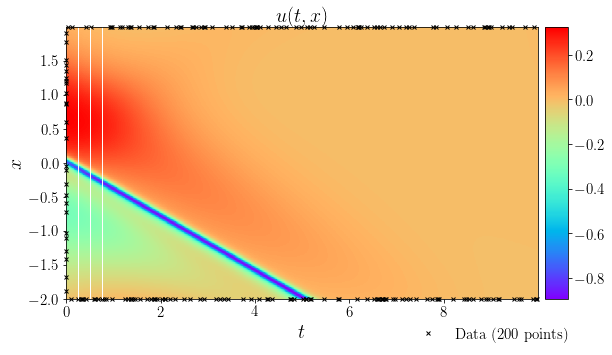

Iter 6100, Loss: 2.01264e-03, Loss_u: 1.07032e-03, Loss_f: 9.42320e-04
Iter 6200, Loss: 2.15080e-03, Loss_u: 1.24672e-03, Loss_f: 9.04074e-04
Iter 6300, Loss: 2.89704e-03, Loss_u: 1.61455e-03, Loss_f: 1.28250e-03
Iter 6400, Loss: 2.18958e-03, Loss_u: 1.28945e-03, Loss_f: 9.00134e-04
Iter 6500, Loss: 1.94842e-03, Loss_u: 1.05267e-03, Loss_f: 8.95755e-04
Iter 6600, Loss: 3.07825e-03, Loss_u: 1.82437e-03, Loss_f: 1.25388e-03
Iter 6700, Loss: 2.70508e-03, Loss_u: 1.68738e-03, Loss_f: 1.01771e-03


KeyboardInterrupt: 

In [67]:
model.train1(20100)

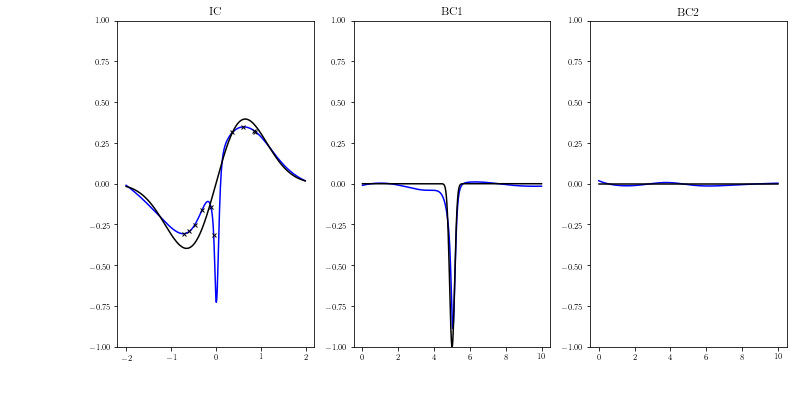

In [68]:
def print_boundaries(model):
    
    u_pred, f_pred = model.predict(X_star)
    x0,t0 = model.x_u.detach().cpu().numpy(),model.t_u.detach().cpu().numpy()
    x_axis = x#(np.arange(l_x)-l_x/2)/128
    t_axis = t#(np.arange(100))/100
    u0,_ = model.predict(np.concatenate((x0,t0),axis=1))
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    
    fig = plt.figure(figsize=(12, 6))


    ax = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    ax.set_title('IC')
    ax.plot(x_axis,U_pred[0,:], color='blue', label='predicted value')
    ax.plot(x_axis,uu1, color='black', label='ground truth')
    ax.plot(
        x0[np.abs(x0)<1],
        u0[np.abs(x0)<1],     
        'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
        markersize = 4,  # marker size doubled
        clip_on = False,
        alpha=1.0,
        color='black')

    ax2.set_title('BC1')
    ax2.plot(t_axis,U_pred[:,0], color='blue', label='predicted value')
    ax2.plot(t_axis,uu2, color='black', label='ground truth')
    ax2.plot(
        t0[x0==-1],
        u0[x0==-1],     
        'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
        markersize = 4,  # marker size doubled
        clip_on = False,
        alpha=1.0,
        color='black')
    
    ax3.set_title('BC2')
    ax3.plot(t_axis,U_pred[:,-1], color='blue', label='predicted value')
    ax3.plot(t_axis,uu3, color='black', label='ground truth')
    ax3.plot(
        t0[x0==1],
        u0[x0==1],     
        'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
        markersize = 4,  # marker size doubled
        clip_on = False,
        alpha=1.0,
        color='black')
#     ax2.set_title('BC1')
#     ax2.plot(y, color='blue', label='Sine wave')
#     ax2.plot(z, color='black', label='Cosine wave')
    
#     ax3.set_title('BC2')
#     ax3.plot(y, color='blue', label='Sine wave')
#     ax3.plot(z, color='black', label='Cosine wave')

    ax.set_ylim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax3.set_ylim([-1, 1])

#     plt.plot(x_axis,U_pred[0,:]);
#     plt.plot(x_axis,uu1);
#     # plt.plot(x0,u0)
#     plt.plot(
#             x0[np.abs(x0)<1],
#             u0[np.abs(x0)<1],     
#             'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
#             markersize = 4,  # marker size doubled
#             clip_on = False,
#             alpha=1.0
#         )
#     plt.figure();
#     plt.plot(t_axis,U_pred[:,0]);
#     plt.plot(t_axis,uu2);
#     plt.plot(
#             t0[x0==-1],
#             u0[x0==-1],     
#             'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
#             markersize = 4,  # marker size doubled
#             clip_on = False,
#             alpha=1.0
#         )
#     plt.figure();
#     plt.plot(t_axis,U_pred[:,-1]);
#     plt.plot(t_axis,uu3);
#     plt.plot(
#             t0[x0==1],
#             u0[x0==1],     
#             'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
#             markersize = 4,  # marker size doubled
#             clip_on = False,
#             alpha=1.0
#         )
    
    plt.show()
    
print_boundaries(model)

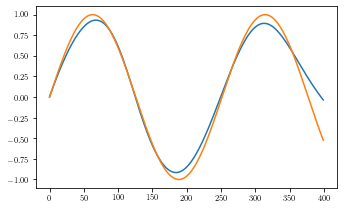

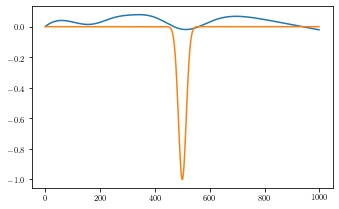

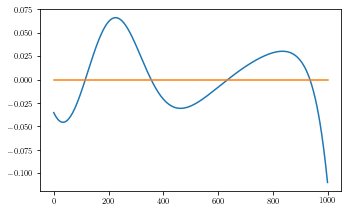

In [52]:
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
plt.plot(U_pred[0,:]);
plt.plot(uu1);
plt.figure();
plt.plot(U_pred[:,0]);
plt.plot(uu2);
plt.figure();
plt.plot(U_pred[:,-1]);
plt.plot(uu3);

In [11]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
# Error = np.abs(Exact - U_pred)



Error u: 5.672333e-01


In [12]:
#start with regular number of points

#train DNN and minimize loss

#add new point

#maximize loss

#train DNN minimize loss